### Set up 
***

#### Notebook settings

In [ ]:
import os 
os.getcwd()

In [ ]:
os.chdir('../')
os.getcwd()

#### Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from production_code import constants

In [158]:
db = pd.read_excel('data/db_us_equity.xlsx')
db.sort_values(by='Date', ascending=True, inplace=True)
db.set_index('Date', inplace=True)
db = db.loc[(db.index <= constants.NON_POW_END_DATE) & (db.index >= constants.NON_POW_START_DATE)]

In [159]:
db.head()

,PX_LAST,PX_VOLUME
Date,,
2007-01-03,105.9943,215662
2007-01-04,106.0413,171227
2007-01-05,104.1851,206596
2007-01-08,103.9267,221408
2007-01-09,103.9032,162289


In [160]:
db.tail()

,PX_LAST,PX_VOLUME
Date,,
2009-06-24,46.1287,1673465
2009-06-25,47.9848,1905159
2009-06-26,48.3373,1190272
2009-06-29,49.0421,914565
2009-06-30,47.7734,1283022


In [161]:
db["LOG_RETURNS"] = np.log(db["PX_LAST"]) - np.log(db["PX_LAST"].shift(-1))

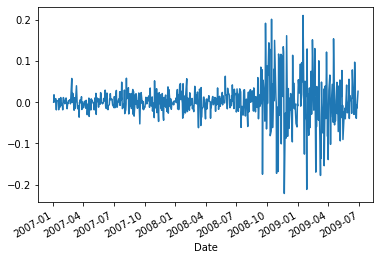

In [162]:
db["LOG_RETURNS"].plot()

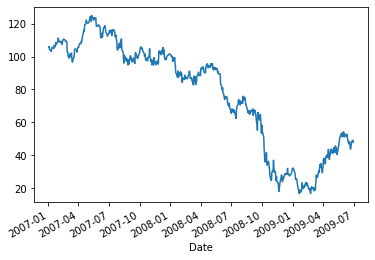

In [163]:
db["PX_LAST"].plot()

### Haar wavelet implementation
***

In [164]:
def firstHalfIndicator(t: float) -> int:
    return ((0 <= t) and (t < 0.5)) * 1

def secondHalfIndicator(t):
    return ((0.5 <= t) and (t < 1)) * 1

def haarMother(t: float) -> int:
    return firstHalfIndicator(t) - secondHalfIndicator(t)

vhaarMother = np.vectorize(haarMother)

In [165]:
x = np.linspace(-2, 2, 100)
y = vhaarMother(x)

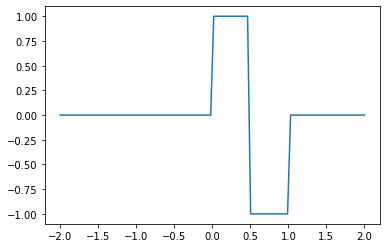

In [166]:
plt.plot(x,y)

In [167]:
def haarWaveletFunction(j: float, k: float, t: float) -> float:
    return pow(2, j / 2) * haarMother(pow(2, j) * t - k)

vhaarWaveletFunction = np.vectorize(haarWaveletFunction)

In [168]:
y1 = vhaarWaveletFunction(0, 0, x)

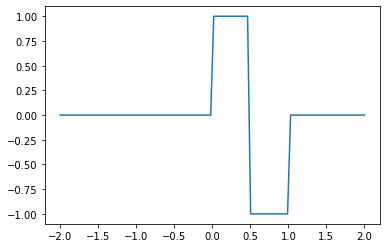

In [169]:
plt.plot(x, y1)

<b>Parameter influence for different wavelet functions</b>

##### Translation parameter

In [170]:
results = [vhaarWaveletFunction(0, j, x) for j in range(-2, 2)]

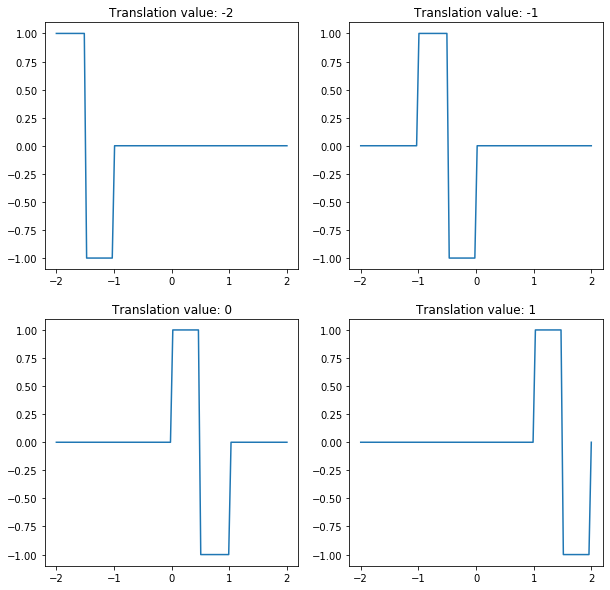

In [171]:
%matplotlib inline
fig, axs = plt.subplots(2,2, figsize=(10,10))
for i, ax in enumerate(fig.axes):
    ax.set_title(f"Translation value: {i - 2}")
    ax.plot(x, results[i])

#### Resolution parameter

In [172]:
results = [vhaarWaveletFunction(j, 0, x) for j in range(0, 4)]

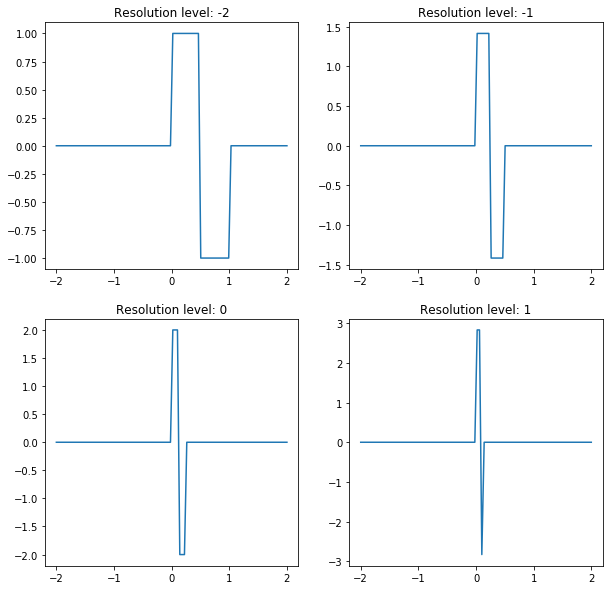

In [173]:
%matplotlib inline
fig, axs = plt.subplots(2,2, figsize=(10,10))
for i, ax in enumerate(fig.axes):
    ax.set_title(f"Resolution level: {i - 2}")
    ax.plot(x, results[i])

In [174]:
results = [vhaarWaveletFunction(-j, 0, x) for j in np.arange(0.0, 4.0)]

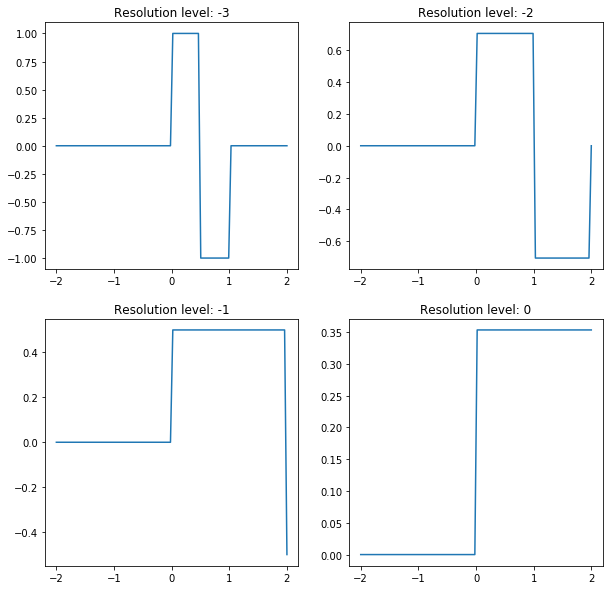

In [175]:
%matplotlib inline
fig, axs = plt.subplots(2,2, figsize=(10,10))
for i, ax in enumerate(fig.axes):
    ax.set_title(f"Resolution level: {i - 3}")
    ax.plot(x, results[i])

### Simulate noisy signal

In [176]:
noisySignal = np.repeat(np.sin(np.linspace(-np.pi, np.pi, 100)), 2) + np.random.randn(200)

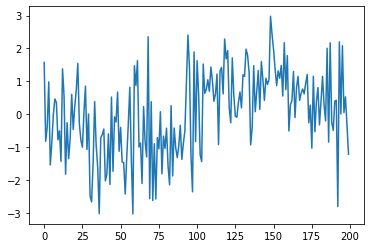

In [177]:
plt.plot(noisySignal)

### Time to denoise it

<b>Determine dyadic grid for scale step j and shift step k</b>

In [178]:
# Parameters
j = -4
t = np.linspace(0, db.shape[0]-1, db.shape[0])
k =  np.linspace(-1, db.shape[0]-2, db.shape[0])

In [179]:
# Shift step
nb_k = int(np.ceil(db.shape[0] / pow(2, -j)) + 2)

In [180]:
# Initialize results
k1 = np.array(np.zeros(nb_k+1))
k2 = np.array(np.zeros(nb_k+1))
coeff = np.array(np.zeros(nb_k+1))

In [181]:
# Scale coefficient
for i in range(0, nb_k+1):
    k1[i] = k[i] * 2**(-j)
    k2[i] = (k[i] + 1) * 2**(-j)
    
    sum1 = 0
    sum2 = 0

    for p in range(0, db.shape[0]):
        if(t[p] >= k1[i]):
            sum1 += db["PX_LAST"].iloc[p]
        if(t[p] >= k2[i]):
            sum2 += db["PX_LAST"].iloc[p]

    coeff[i] = 2**(j/2) * (sum1 - sum2)

In [182]:
# Initialisations
t1 = np.array(np.zeros(db.shape[0]-1))
t2 = np.array(np.zeros(db.shape[0]-1))
approx = np.array(np.zeros(db.shape[0]))

In [183]:
# Approximation
for i in range(1, db.shape[0]):
    t1[i-1] = 2**j * t[i-1] - 1
    t2[i-1] = 2**j * t[i-1]
    
    sum1 = 0
    sum2 = 0
    for p in range(0, nb_k):
        if(k[p] >= t1[i-1]):
            sum1 += coeff[p]
        if(k[p] >= t2[i-1]):
            sum2 += coeff[p]
        
    approx[i] = 2**(j/2) * (sum1 - sum2)

In [184]:
coeff = coeff[1:np.size(coeff)-3]    
approx = approx[2:db.shape[0]-2**(-j)]

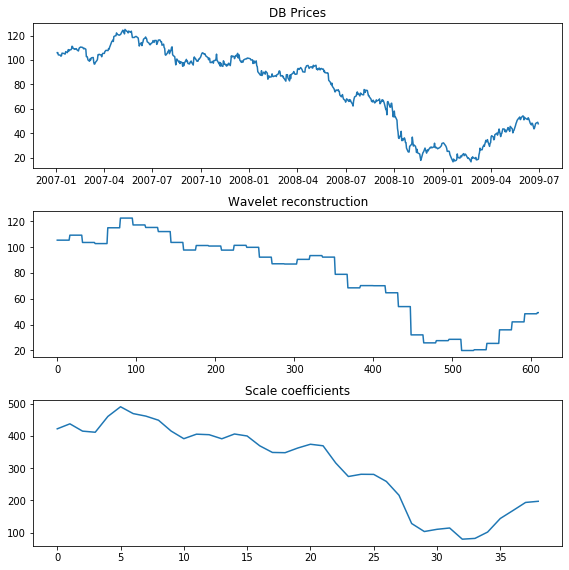

In [188]:
fig, ax = plt.subplots(3,1, figsize=(8,8))
ax[0].plot(db["PX_LAST"])
ax[0].set_title("DB Prices")
ax[1].plot(approx)
ax[1].set_title("Wavelet reconstruction")
ax[2].plot(coeff)
ax[2].set_title("Scale coefficients")
fig.tight_layout(pad=1)